# <font color = '#00CCFF'> High Value Customer Identification </font>

Project Objective: Find significant customers for the business who make high purchases of their favourite products. The organization wants to roll out a loyalty program to the high-value customers after identification of segments. Use the clustering methodology to segment customers into groups:

Dataset Description: This is a transnational dataset that contains all the transactions occurring between Nov-2016 to Dec-2017 for a UK-based online retail store.

Attribute Description:
- InvoiceNo: Invoice number (A 6-digit integral number uniquely assigned to each transaction)
- StockCode: Product (item) code
- Description: Product (item) name
- Quantity: The quantities of each product (item) per transaction
- InvoiceDate: The day when each transaction was generated
- UnitPrice: Unit price (Product price per unit)
- CustomerID: Customer number (Unique ID assigned to each customer)
- Country: Country name (The name of the country where each customer resides)

# 0. Imports

## 0.1. Libraries

In [130]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import plotly.express as px
#%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor

import umap.umap_ as umap

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from ydata_profiling import ProfileReport

## 0.2. Functions

In [2]:
# Save intermediate dataset
def save_interim(dataframe, file_name):
   dataframe.to_csv('../data/interim/'+file_name+'.zip', index=False, compression= 'zip')

# Load intermediate dataset
def load_interim(file_name):
   return pd.read_csv('../data/interim/'+file_name, compression='zip')

## 0.3. Load dataset

In [3]:
path = '/home/ezequiel/Documentos/Comunidade_DS/insiders_clustering/data/raw/Ecommerce.zip'
df_raw = pd.read_csv(path, encoding='unicode_escape', compression='zip')
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1. Descrição dos dados

In [5]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols

## 1.2. Data dimensions

In [8]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data types

InvoiceNo should be a number, but some records have letters

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [11]:
# Procurar se há algum customer_id "perdido" a partir do invoice_no
df_missing = df1[df1['customer_id'].isna()]
df_not_missing = df1[~df1['customer_id'].isna()]

In [12]:
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()

In [13]:
# Os invoice_no dos customer_id faltantes não correspondem a nenhum invoice_no que possui um customer_id
df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [14]:
df_not_missing['customer_id'].max()

18287.0

In [15]:
# Alternativa: atribuir um customer_id não utilizado para cada invoice_no único que não possui customer_id
aux = df_missing[['invoice_no']].drop_duplicates()
aux['customer_id'] = np.arange(19000, 19000+len(aux), 1)

df1 = pd.merge(df1, aux, on='invoice_no', how='left')
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])
df1.drop(columns=['customer_id_x', 'customer_id_y'], inplace=True)

In [16]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [17]:
df1 = df1.dropna(subset=['description', 'customer_id'])

## 1.6. Change dtyper

In [18]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [19]:
# invoice_date -> to datetime
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id -> to int
df1['customer_id'] = df1['customer_id'].astype(int)

In [20]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [21]:
save_interim(dataframe=df1, file_name='df1.csv')

## 1.7. Descriptive statistics

In [21]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include='object')

### 1.7.1. Numerical attributes

In [22]:
df_describe = num_attributes.describe().T
df_describe['range'] = df_describe['max'] - df_describe['min']
df_describe['median'] = num_attributes.median()
df_describe['skewness'] = num_attributes.skew()
df_describe['kurtosis'] = num_attributes.kurtosis()
df_describe.reset_index()

,index,count,mean,std,min,25%,50%,75%,max,range,median,skewness,kurtosis
0,quantity,540455.0,9.603129,218.007598,-80995.00,1.00,3.00,10.00,80995.0,161990.00,3.00,-0.281253,120252.449063
1,unit_price,540455.0,4.623519,96.889628,-11062.06,1.25,2.08,4.13,38970.0,50032.06,2.08,186.257919,58848.017575
2,customer_id,540455.0,16678.153600,2907.572952,12346.00,14364.00,16241.00,18257.00,22709.0,10363.00,16241.00,0.493600,-0.792496


<font color='red'>**OBSERVAÇÕES:**</font>
- quantity com mínimo negativo (devolução?)
- quantity com valor max e min iguais em módulo
- unit_price com min = zero (promoção?)

### 1.7.2. Categorical attributes

#### Invoice_no

In [23]:
# verifica se invoice_no contém, ao menos, uma letra e agrupa por invoice_no para o dataframe inteiro
aux = df1[df1['invoice_no'].str.contains('[a-zA-Z]')].groupby('invoice_no').count().reset_index()
print(f'Qtd de invoices únicos com letras: {len(aux)}')
print(f'Qtd total de invoices com letras {aux["stock_code"].sum()}')

Qtd de invoices únicos com letras: 3839
Qtd total de invoices com letras 9291


In [24]:
aux = len(df1.loc[df1['invoice_no'].str.contains('[a-zA-Z]'), ['quantity']])
print(f'Qtd de invoices com letras onde a quantidade é negativa: {aux}')

Qtd de invoices com letras onde a quantidade é negativa: 9291


#### Stock_code

In [25]:
# verifica se stock_code contém, ao menos, uma letra e conta quantos são
df1[df1['stock_code'].str.contains('[a-zA-Z]')]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
...,...,...,...,...,...,...,...,...
541778,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,2017-12-07,4.15,Germany,12713
541809,581579,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2017-12-07,1.79,United Kingdom,17581
541838,581580,84993A,75 GREEN PETIT FOUR CASES,2,2017-12-07,0.42,United Kingdom,12748
541844,581580,85049A,TRADITIONAL CHRISTMAS RIBBONS,1,2017-12-07,1.25,United Kingdom,12748


In [26]:
# verifica se stock_code contém somente letras e mostra a quantidade de ocorrências
df1.loc[~df1['stock_code'].str.contains('[0-9]'), 'stock_code'].value_counts()

stock_code
POST            1252
DOT              709
M                571
D                 77
S                 63
BANK CHARGES      37
AMAZONFEE         34
CRUK              16
DCGSSGIRL         13
DCGSSBOY          11
PADS               4
B                  3
m                  1
Name: count, dtype: int64

In [27]:
df1.loc[~df1['stock_code'].str.contains('[0-9]'), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE', 'm',
       'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Country

In [28]:
df1['country'].value_counts(normalize=True)

country
United Kingdom          0.914089
Germany                 0.017569
France                  0.015833
EIRE                    0.015165
Spain                   0.004687
Netherlands             0.004387
Belgium                 0.003828
Switzerland             0.003704
Portugal                0.002811
Australia               0.002330
Norway                  0.002009
Italy                   0.001486
Channel Islands         0.001403
Finland                 0.001286
Cyprus                  0.001151
Sweden                  0.000855
Unspecified             0.000825
Austria                 0.000742
Denmark                 0.000720
Japan                   0.000662
Poland                  0.000631
Israel                  0.000550
USA                     0.000538
Hong Kong               0.000533
Singapore               0.000424
Iceland                 0.000337
Canada                  0.000279
Greece                  0.000270
Malta                   0.000235
United Arab Emirates    0.000126
Eu

<font color='red'>**OBSERVAÇÕES:**</font>
- invoice_no possui:
    - 3839 entradas únicas que possuem letras
    - 9291 entradas totais que possuem letras
    - todas as entradas com letras correspondem à uma quantity negativa, indicando uma operação de cancelamento de venda
- stock_code que possuem somente letras:
    - BANK CHARGES -> qtd: 37
    - AMAZONFEE ->    qtd: 34
    - CRUK ->         qtd: -16
    - D ->            qtd: 77
    - DOT ->          qtd: 710
    - M ->            qtd: 571
    - S ->            qtd: 63
    - POST ->         qtd: 1256
    - DCGSSGIRL ->    qtd: 13
    - DCGSSBOY ->     qtd: 11
    - PADS ->         qtd: 4
    - B ->            qtd: 3
    - m ->            qtd: 1
- description:
    - deletar coluna pois, a princípio, não tem relevância como feature
- country:
    - 91,43% está no Reino Unido

# 2. Variables Filtering

In [29]:
df2 = df1.copy()

In [30]:
df2.query('quantity < 0').sort_values('quantity').head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,United Kingdom,16446
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2017-01-16,1.04,United Kingdom,12346
225529,556690,23005,printing smudges/thrown away,-9600,2017-06-12,0.00,United Kingdom,20914
225530,556691,23005,printing smudges/thrown away,-9600,2017-06-12,0.00,United Kingdom,20915
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.03,United Kingdom,15838


In [31]:
df2.query('customer_id == 20914')

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
225529,556690,23005,printing smudges/thrown away,-9600,2017-06-12,0.0,United Kingdom,20914


In [32]:
# selecionar somente preços maiores que 4 centavo
df2 = df2.query('unit_price >= 0.04')

In [33]:
# retirar alguns stock_codes
codes = ['POST', 'D', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 = df2.query('stock_code != @codes')

In [34]:
df2 = df2.drop(columns='description')

In [35]:
drop_country = ['European Community', 'Unspecified']
df2 = df2.query('country != @drop_country')

In [36]:
# separar as quantidades negativas como devoluções (cancelamentos)
df2_returns = df2.query('quantity < 0')
df2_purchases = df2.query('quantity >= 0')

# 3. Feature Engineering

In [63]:
df3 = df2.copy()

In [64]:
# data reference - group by customer
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


#### **Gross revenue (Faturamento)**

Faturamento para cada produto = quantidade x preço

In [65]:
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

/tmp/ipykernel_11547/2099251183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']


In [66]:
# total value of purchases per customer
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

#### **Recency**

How recent is the last purchase made by each customer.

In [67]:
# find the last purchase date of each customer and subtracts of the overall last purchase date
df_last_purchase = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_last_purchase['recency'] = (df_last_purchase['invoice_date'].max() - df_last_purchase['invoice_date']).dt.days
df_ref = pd.merge(df_ref, df_last_purchase, on='customer_id', how='left')

In [68]:
df_ref.isna().sum()

customer_id       0
gross_revenue    67
invoice_date     67
recency          67
dtype: int64

#### **Quantity of purchases**

Consider the unique invoice_no (transaction)

In [69]:
df_freq = df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'qtd_invoices'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,invoice_date,recency,qtd_invoices
0,17850,5391.21,2016-11-30,372.0,34.0
1,13047,3232.59,2017-10-12,56.0,9.0
2,12583,6705.38,2017-12-05,2.0,15.0
3,13748,948.25,2017-09-03,95.0,5.0
4,15100,876.00,2017-01-08,333.0,3.0


In [70]:
df_ref.isna().sum()

customer_id       0
gross_revenue    67
invoice_date     67
recency          67
qtd_invoices     67
dtype: int64

#### **Quantity of items purchased**

In [71]:
aux = df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtd_items'})
df_ref = pd.merge(df_ref, aux, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
invoice_date     67
recency          67
qtd_invoices     67
qtd_items        67
dtype: int64

#### **Quantity of products purchased**

In [72]:
aux = df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'qtd_products'})
df_ref = pd.merge(df_ref, aux, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
invoice_date     67
recency          67
qtd_invoices     67
qtd_items        67
qtd_products     67
dtype: int64

#### **Average ticket**

Average spend of each client

In [73]:
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

In [74]:
df_ref.isna().sum()

customer_id       0
gross_revenue    67
invoice_date     67
recency          67
qtd_invoices     67
qtd_items        67
qtd_products     67
avg_ticket       67
dtype: int64

#### **Average recency days**

Average days between purchases

In [75]:
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days*-1 if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         67
invoice_date          67
recency               67
qtd_invoices          67
qtd_items             67
qtd_products          67
avg_ticket            67
avg_recency_days    2794
dtype: int64

#### **Frequency purchase**

In [76]:
df_aux = df3[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id').agg(
                                                            max_inv_date = ('invoice_date', max),
                                                            min_inv_date = ('invoice_date', min),
                                                            days = ('invoice_date', lambda x: (x.max() - x.min()).days + 1),
                                                            buy = ('invoice_no', 'count')).reset_index()

In [77]:
# Frequency
df_aux['frequency'] = df_aux[['buy', 'days']].apply(lambda x: x['buy']/x['days'] if x['days'] != 0 else 0, axis=1)

In [78]:
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
gross_revenue         67
invoice_date          67
recency               67
qtd_invoices          67
qtd_items             67
qtd_products          67
avg_ticket            67
avg_recency_days    2794
frequency              0
dtype: int64

#### **Number of returns**

In [79]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'returns'})
df_returns['returns'] = df_returns['returns'] * -1

In [80]:
df_ref= pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0

In [81]:
df_ref.isna().sum()

customer_id            0
gross_revenue         67
invoice_date          67
recency               67
qtd_invoices          67
qtd_items             67
qtd_products          67
avg_ticket            67
avg_recency_days    2794
frequency              0
returns                0
dtype: int64

#### **Basket size** (quantidade de itens por cesta)

In [82]:
df_aux = df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id').agg(
                                                                        n_purchase = ('invoice_no', 'nunique'),
                                                                        n_products = ('quantity', 'sum')).reset_index()

In [83]:
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

In [84]:
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         67
invoice_date          67
recency               67
qtd_invoices          67
qtd_items             67
qtd_products          67
avg_ticket            67
avg_recency_days    2794
frequency              0
returns                0
avg_basket_size       67
dtype: int64

#### **Unique Basket size** (quantidade de itens distintos por cesta)

In [85]:
df_aux = df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id').agg(
                                                                        n_purchase = ('invoice_no', 'nunique'),
                                                                        n_products = ('stock_code', 'nunique')).reset_index()

In [86]:
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

In [87]:
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id                  0
gross_revenue               67
invoice_date                67
recency                     67
qtd_invoices                67
qtd_items                   67
qtd_products                67
avg_ticket                  67
avg_recency_days          2794
frequency                    0
returns                      0
avg_basket_size             67
avg_unique_basket_size      67
dtype: int64

In [88]:
df_ref.drop(columns=['invoice_date'], inplace=True)
df_ref.head()

,customer_id,gross_revenue,recency,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,0.486111,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.048780,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.045699,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.136364,22.0,26.666667,0.333333


# 4. EDA (Exploratory Data Analysis)

In [89]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency                   0
qtd_invoices              0
qtd_items                 0
qtd_products              0
avg_ticket                0
avg_recency_days          0
frequency                 0
returns                   0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1. Univariate Analysis

**What I want**
1. Clusters coesos - separados
2. Métricas:
    - min, max, range
    - média e mediana
    - desvio padrão e variância
    - coeficiente de variação (std / mean) --> quanto menor o valor, mais próximo da média estão os valores; pouca variação em relação à média
    - distribuição

In [67]:
profile = ProfileReport(df4)
profile.to_file('../reports/output.html')

/home/ezequiel/.pyenv/versions/ins_clustering/lib/python3.10/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**What I see**

### 4.1.1. Gross revenue

In [90]:
df4.query('gross_revenue ==  279138.02')

,customer_id,gross_revenue,recency,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
1014,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.206215,288.0,2733.944444,9.708333


<Axes: xlabel='gross_revenue', ylabel='Count'>

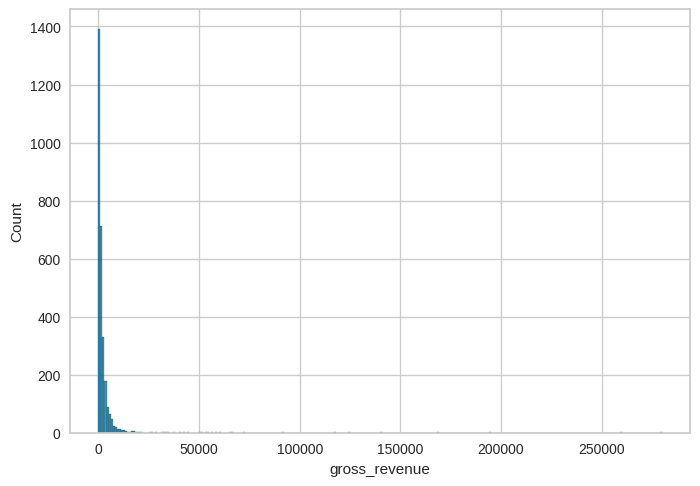

In [91]:
sns.histplot(df4['gross_revenue'], binwidth=1000)

### 4.1.2. Recency

<Axes: xlabel='recency', ylabel='Count'>

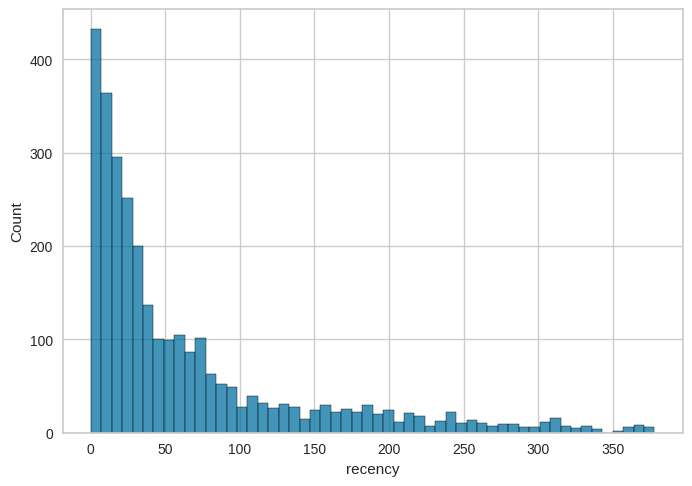

In [92]:
sns.histplot(df4['recency'], binwidth=7)

#### 4.1.3. Qtd products

In [93]:
df4.query('qtd_products == 7838')

,customer_id,gross_revenue,recency,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
68,17841,40967.72,1.0,124.0,23053.0,7838.0,5.226808,3.321429,0.453083,203.0,185.91129,10.66129


### 4.1.4. Avg ticket

In [94]:
df4.query('avg_ticket == 56157.5')

,customer_id,gross_revenue,recency,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
3325,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,205.0,0.014563,80995.0,40498.5,1.5


In [95]:
df1.query('customer_id == 16446')

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,PANTRY PASTRY BRUSH,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,United Kingdom,16446


## 4.2. Bivariate Analysis

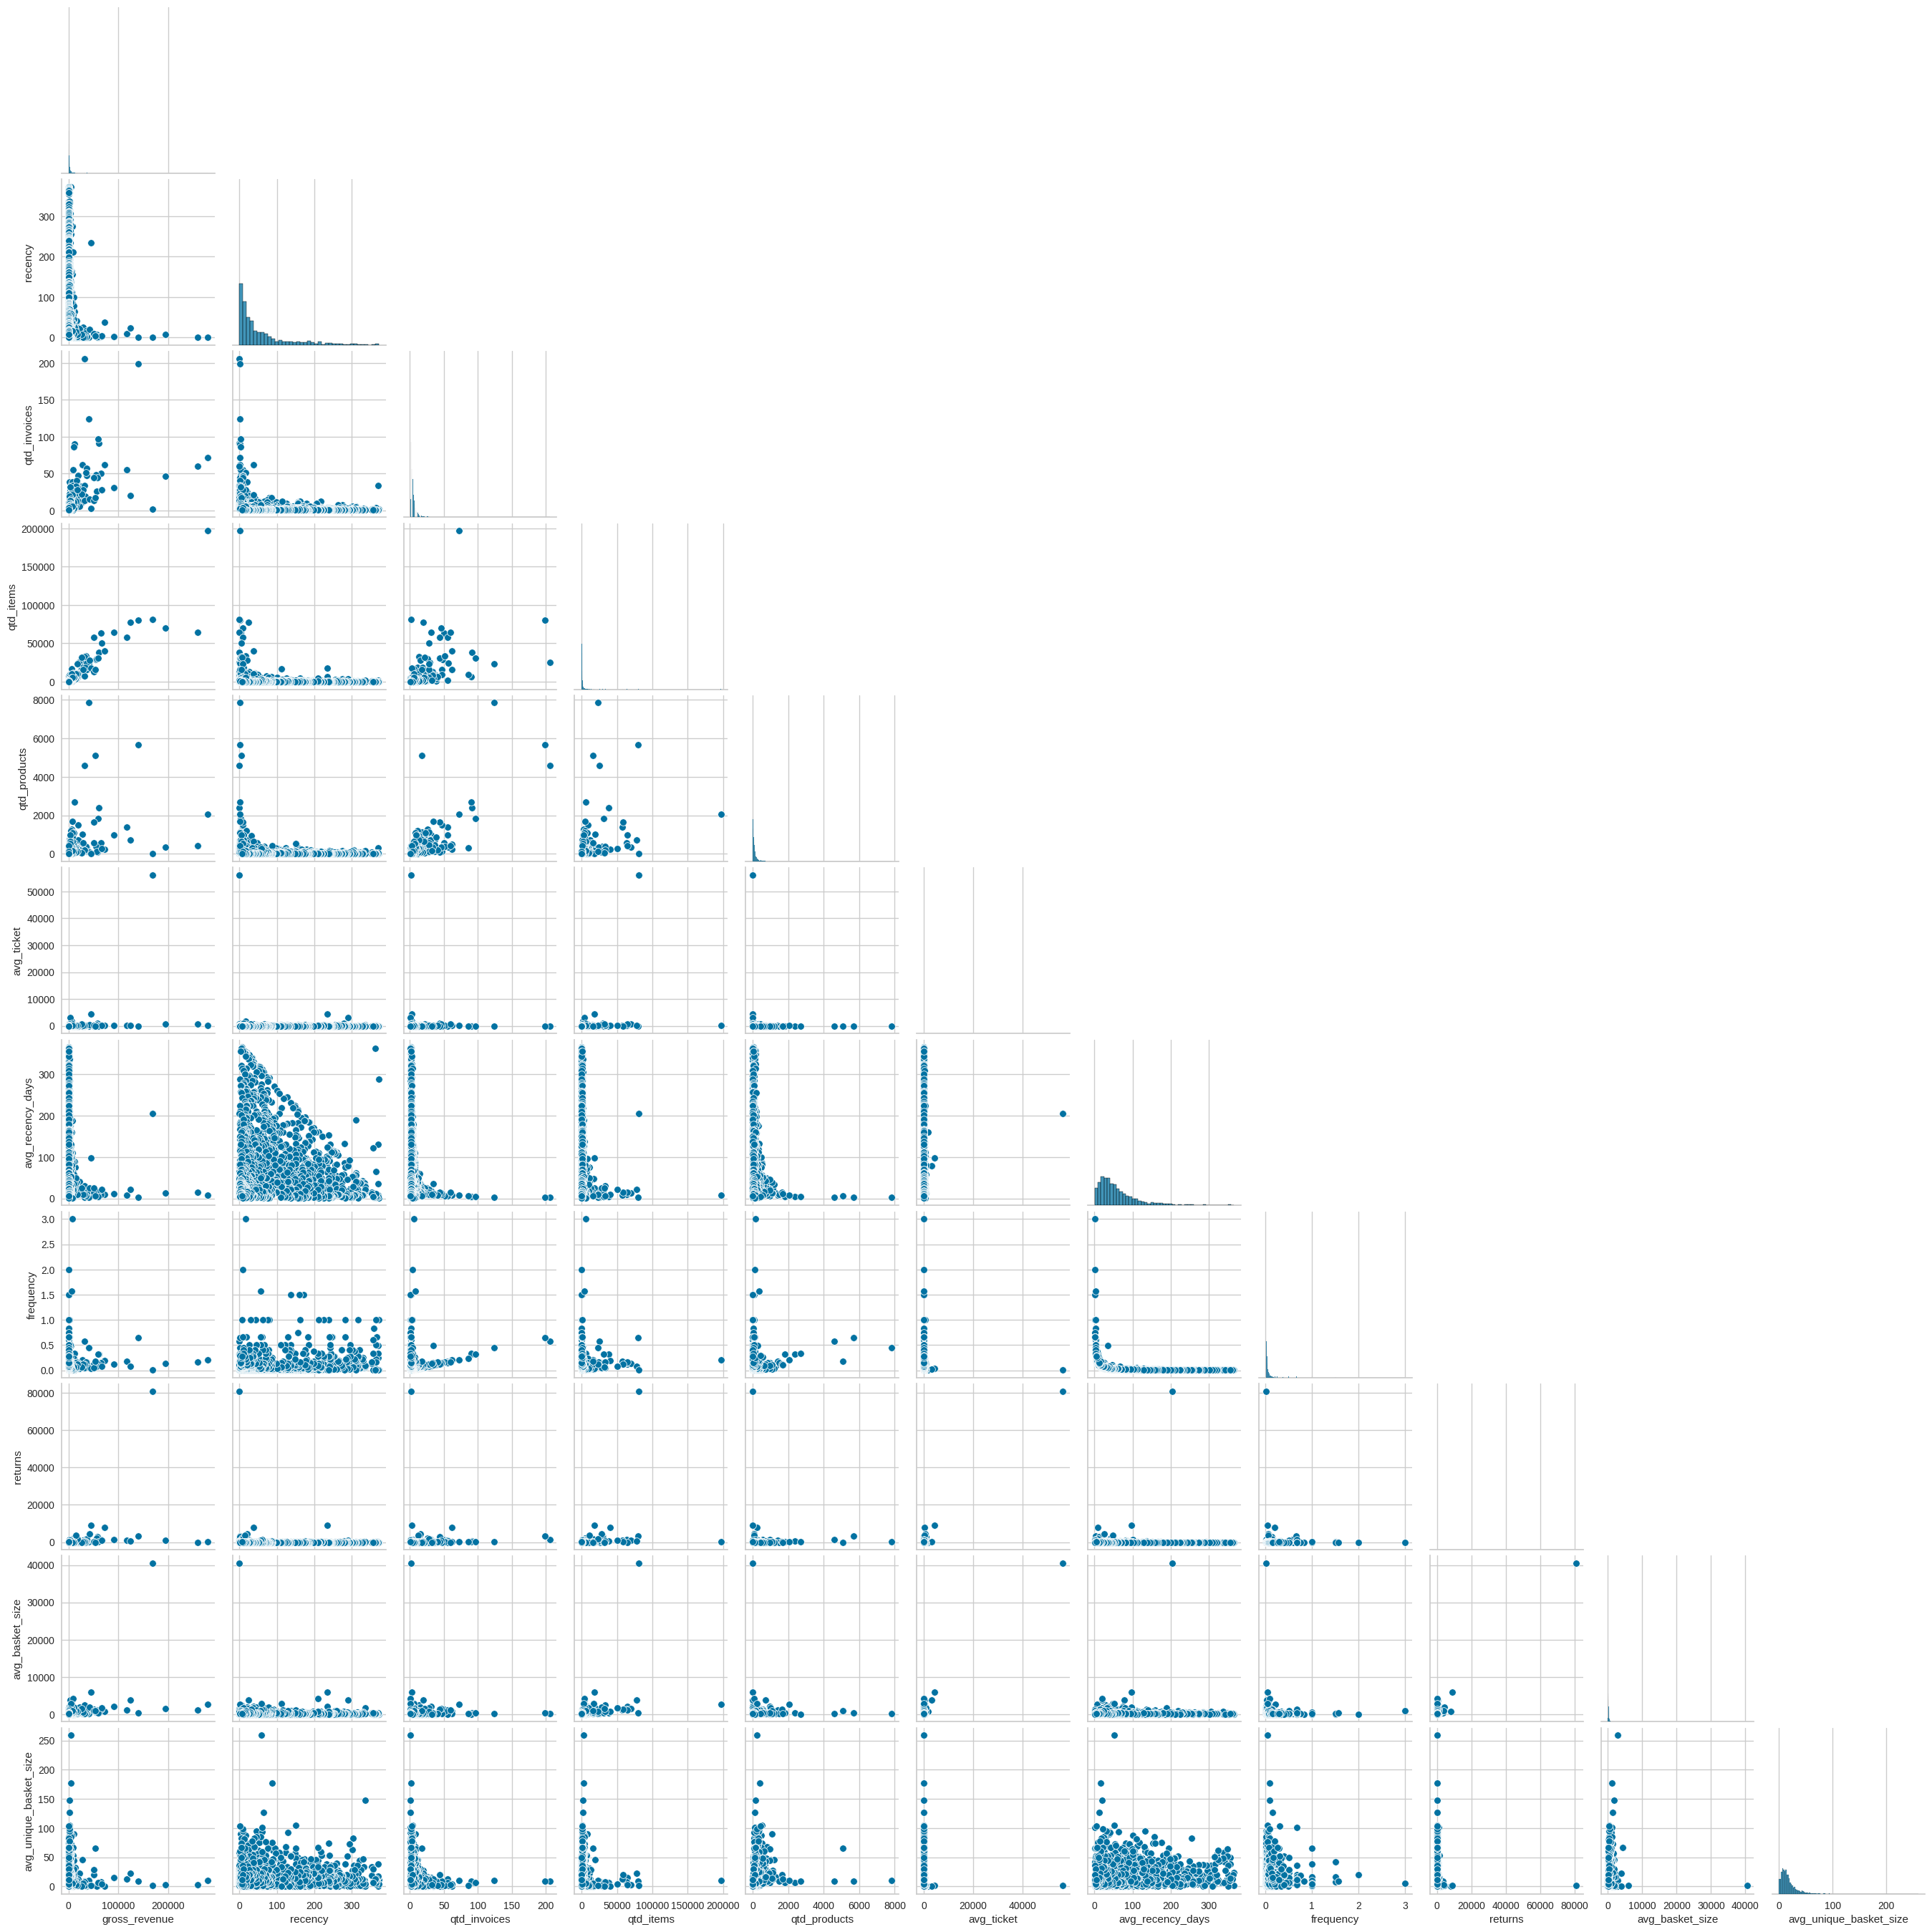

In [96]:
sns.pairplot(data=df4.drop(columns=['customer_id']), corner=True)

## 4.3. Estudo do Espaço

In [104]:
df43 = df4.drop(columns='customer_id')

In [105]:
df43.columns

Index(['gross_revenue', 'recency', 'qtd_invoices', 'qtd_items', 'qtd_products',
       'avg_ticket', 'avg_recency_days', 'frequency', 'returns',
       'avg_basket_size', 'avg_unique_basket_size'],
      dtype='object')

In [106]:
mm = MinMaxScaler()

In [107]:
df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency'] = mm.fit_transform(df43[['recency']])
df43['qtd_invoices'] = mm.fit_transform(df43[['qtd_invoices']])
df43['qtd_items'] = mm.fit_transform(df43[['qtd_items']])
df43['qtd_products'] = mm.fit_transform(df43[['qtd_products']])
df43['avg_ticket'] = mm.fit_transform(df43[['avg_ticket']])
df43['avg_recency_days'] = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['returns'] = mm.fit_transform(df43[['returns']])
df43['avg_basket_size'] = mm.fit_transform(df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

In [108]:
X = df43.copy()

### 4.3.1. PCA

In [110]:
X.shape

(2966, 11)

In [117]:
X.head()

,gross_revenue,recency,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.160976,0.008794,0.037770,0.000285,0.094521,0.160512,0.000494,0.001234,0.001614
1,0.011559,0.150134,0.039024,0.007051,0.021692,0.000298,0.071918,0.014470,0.000432,0.003789,0.044307
2,0.024000,0.005362,0.068293,0.025533,0.029476,0.000476,0.060788,0.013441,0.000617,0.008252,0.028594
3,0.003375,0.254692,0.019512,0.002220,0.003445,0.000565,0.251142,0.004165,0.000000,0.002143,0.017774
4,0.003116,0.892761,0.009756,0.000396,0.000255,0.005162,0.020822,0.043717,0.000272,0.000634,0.000515


In [112]:
pca = PCA(n_components=X.shape[1])
principal_components = pca.fit_transform(X)

<BarContainer object of 11 artists>

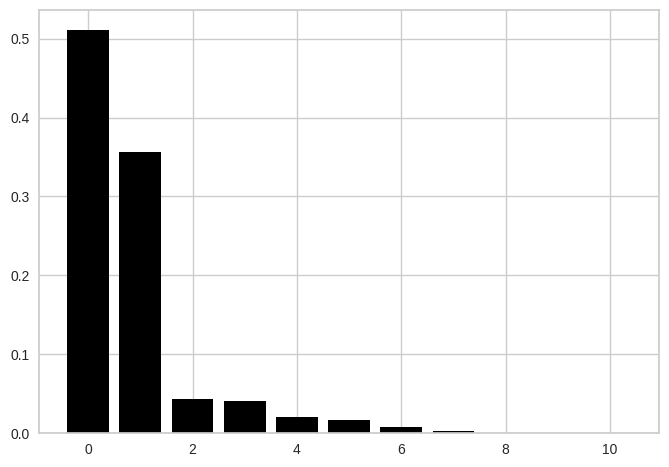

In [114]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')

# Mostra em quais eixos acontece a maior variação dos dados. Cada eixo é uma feature

<Axes: title={'center': 'PCA Component Explained Variances'}, xlabel='First n principal components', ylabel='Explained variance ratio of first n components'>

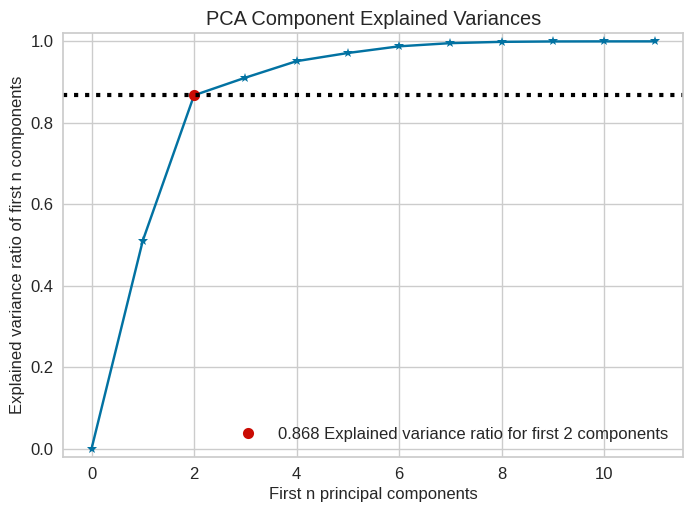

In [115]:
skplt.decomposition.plot_pca_component_variance(pca)

<Axes: xlabel='0', ylabel='1'>

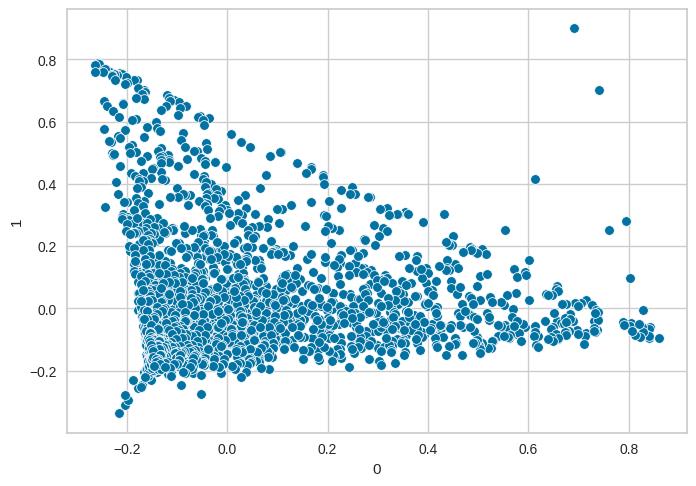

In [119]:
df_pca = pd.DataFrame(principal_components)

sns.scatterplot(data=df_pca, x=0, y=1)

### 4.3.2. UMAP

In [120]:
reducer = umap.UMAP(n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

/home/ezequiel/.pyenv/versions/ins_clustering/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

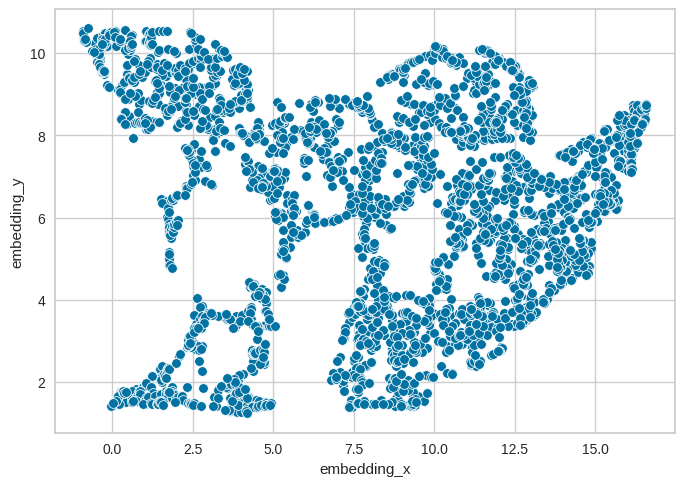

In [122]:
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca)

### 4.3.3. t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

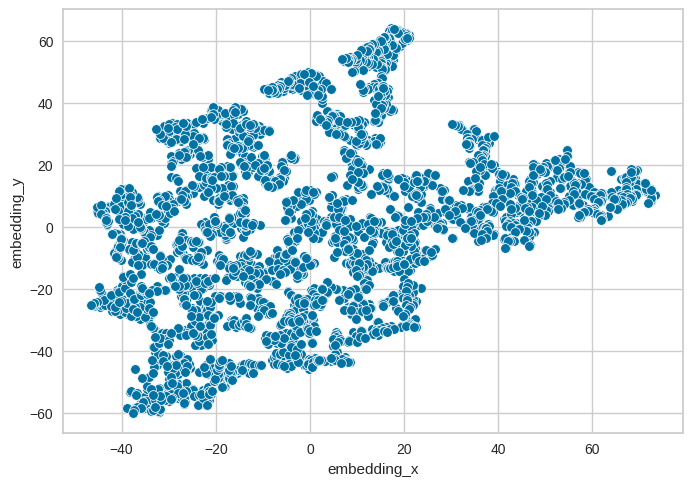

In [125]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca)

### 4.3.4. Tree-Based Embedding

In [128]:
X = df4.drop(columns=['customer_id','gross_revenue'])
y = df4['gross_revenue']

In [133]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X, y)

df_leaf = pd.DataFrame(rf_model.apply(X))
# Retorna uma tabela onde as colunas representam uma árvore e as linhas, cada customer.
# O Valor retornado é o índice da folha que aquele customer se encontra, naquela árvore indicada pela coluna

/home/ezequiel/.pyenv/versions/ins_clustering/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

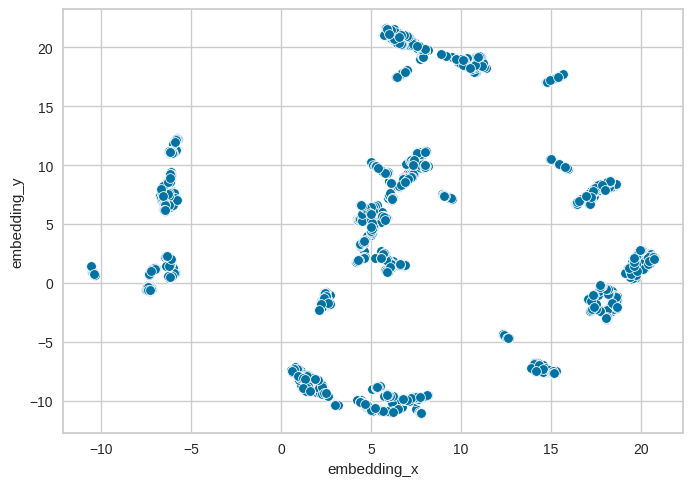

In [136]:
# Redução de dimensionalidade
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca)

# 5. Data Preparation

In [ ]:
df5 = df4.copy()

In [ ]:
std_scaler =StandardScaler()

df5['gross_revenue'] = std_scaler.fit_transform(df5[['gross_revenue']])
df5['recency'] = std_scaler.fit_transform(df5[['recency']])
df5['invoice_no'] = std_scaler.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = std_scaler.fit_transform(df5[['avg_ticket']])
#df5['returns'] = std_scaler.fit_transform(df5[['returns']])

# 6. Feature Selection

In [ ]:
df6 = df5.copy()

# 7. Hyperparameter Fine Tunning

In [ ]:
df7 = df5.drop(columns=['returns'])
df7.head()

In [ ]:
df7.describe()

## 7.1. Within-Cluster Sum of Squares (WSS)

Returns the compactness of the clusters. It is global measure and does not tell if the clusters are well separated or if there is overlaping between them.

In [ ]:
clusters = [2, 3, 4, 5, 6, 7]
model = KMeans(n_init=10)
elbow = KElbowVisualizer(estimator=model, k=clusters)
elbow.fit(df7)
elbow.show()

In [ ]:
S = KElbowVisualizer(estimator=model, k=clusters, metric='silhouette', timings=False)
S.fit(df7)
S.show()

## 7.2. Silhouette Analysis

Measures how well a point fits into its cluster compared to the others.

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(16,20))

for k in clusters:
    km_model = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    x, y = divmod(k, 2)
    SS = SilhouetteVisualizer(estimator=km_model, colors='yellowbrick', ax=ax[x-1][y])
    SS.fit(df7)
    SS.finalize()
    #SS.show()

# 8. Model Training

## 8.1. K-Means

In [ ]:
k = 3

kmeans = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, random_state=42)
kmeans.fit(df7)
labels = kmeans.predict(df7)

### 8.1.1. Validation

In [ ]:
# WSS
print(f'WSS: {kmeans.inertia_}')

# SS
print(f'Silhouette score: {silhouette_score(X=df7, labels=labels, metric="euclidean")}')

# 9. Cluster Analisys

In [ ]:
df9 = df7.copy()
df9['cluster'] = labels
df9.head()

## 9.1. Visualization

In [ ]:
df7.head()

In [ ]:
SS_fig = SilhouetteVisualizer(kmeans, colors='sns_dark')
SS_fig.fit(df7)
SS_fig.show()

In [ ]:
#fig = px.scatter_3d(data_frame=df9, x='gross_revenue', y='recency', z='invoice_no', color='cluster', width=600, height=600)
#fig.show()

In [ ]:
df9.head()

### 9.1.1. 2d plot

In [ ]:
df_viz = df9.drop(columns='customer_id')
sns.pairplot(data=df_viz, hue='cluster', corner=True, palette='Set1')

### 9.1.2. UMAP

Ferramenta para visualização de dados com alta dimensionalidade em um plano 2D.
- Clusters com boa definição (bom agrupamento) em 2D indicam um bom agrupamento na alta dimensionalidade

In [ ]:
df9.head()

In [ ]:
reducer = umap.UMAP(n_neighbors=90, n_jobs=-1)
embedding = reducer.fit_transform(df9)

df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

In [ ]:
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

## 9.2. Cluster profile

In [ ]:
df9['gross_revenue'].sum()

In [ ]:
df9[['cluster', 'gross_revenue']].groupby('cluster').sum() / df9['gross_revenue'].sum()

In [ ]:
# Number of customers
df_clusters = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()

# Number of customers (%)
df_clusters['% customer_id'] = (df_clusters[['customer_id']] / df_clusters[['customer_id']].sum()) * 100

# Average gross revenue
aux1 = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()

# % Gross revenue
aux2 = (df9[['cluster', 'gross_revenue']].groupby('cluster').sum() / df9['gross_revenue'].sum()).reset_index().rename(columns={'gross_revenue': '% gross_revenue'})

# Average recency
aux3 = df9[['recency', 'cluster']].groupby('cluster').mean().reset_index()

# Average invoice no
aux4 = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()

# Average ticket
aux5 = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()

In [ ]:
df_clusters = pd.merge(df_clusters, aux1, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux2, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux3, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux4, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux5, on='cluster', how='left')
df_clusters

---

**Cluster 1 (candidatos à insiders)**:
- Número de customers: 267 (6,1%)
- Recência média: 20,28
- Média de compras: 19,5
- Média de receita: US$ 8.089,00
- Ticket médio: US$ 62,78
---

**Cluster 2**:
- Número de customers: 6 (0,14%)
- Recência média: 7,16
- Média de compras: 89
- Média de receita: US$ 182.181,98
- Ticket médio: US$ 253,62
---

**Cluster 3**:
- Número de customers: 28 (0,64%)
- Recência média: 6,18
- Média de compras: 57,82
- Média de receita: US$ 42.614,39
- Ticket médio: US$ 162,86
---

**Cluster 4**:
- Número de customers: 4071 (93,1%)
- Recência média: 96,96
- Média de compras: 3,64
- Média de receita: US$ 946,69
- Ticket médio: US$ 25,35
---

# 10. Deploy to Production